In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from sklearn import manifold

In [34]:
import torch
import sys
import os
import importlib
import torch
import numpy
import torch.nn.functional as F
from scipy.io import wavfile
from scipy import signal
from collections import defaultdict
import pickle
import random
# from asnorm import *

In [4]:
# make cohort set

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [15]:
sys.path.append('/workspace/GREAT_ASV_system/train_dist')

In [7]:
# from DatasetLoader import loadWAV

In [16]:
SpeakerNetModel = importlib.import_module('models.'+'EPACA-TDNN').__getattribute__('MainModel')

In [17]:
# EPACA-TDNN
S = SpeakerNetModel(n_mels=40, nOut=192, spec_aug=False)

EPACA-TDNN.py, Embedding size is 192, Channels 1024, Spec_aug False.


In [18]:
model_path = '/workspace/LOGS_OUTPUT/server9_nvme1/ASV_LOGS_202102/train_logs_201120/sdsv21_full_pretrain/model/model000000024.model'

In [7]:
# S.cuda()

ECAPA_TDNN(
  (instancenorm): InstanceNorm1d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (torchfb): Sequential(
    (0): PreEmphasis()
    (1): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (layer1): Conv1dReluBn(
    (conv): Conv1d(40, 1024, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (2): Conv1d(128, 128, kernel_size=(3,), 

In [19]:
loaded_state = torch.load(model_path, map_location="cpu")

In [20]:
# self_state = self.__model__.module.state_dict()
# loaded_state = torch.load(path, map_location="cuda:%d"%self.gpu)
# loaded_state = torch.load(path, map_location="cpu")
self_state = S.state_dict()

for name, param in loaded_state['model'].items():
    origname = name

    ## pass spk clf weight
    if '__L__' in name:
        print('pass __L__ classerfier W')
        continue

    ## pass DA weight
    if 'DA_module' in name:
        print('pass DA_module params:'+name)
        continue

    if name not in self_state:
        name = name.replace("__S__.", "")

        if name not in self_state:
            print("#%s is not in the model."%origname)
            continue

    if self_state[name].size() != loaded_state['model'][origname].size():
        print("#Wrong parameter length: %s, model: %s, loaded: %s"%(origname, self_state[name].size(), loaded_state['model'][origname].size()))
        continue

    self_state[name].copy_(param)

pass __L__ classerfier W


In [21]:
S.eval()

ECAPA_TDNN(
  (instancenorm): InstanceNorm1d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (torchfb): Sequential(
    (0): PreEmphasis()
    (1): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (layer1): Conv1dReluBn(
    (conv): Conv1d(40, 1024, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (2): Conv1d(128, 128, kernel_size=(3,), 

In [31]:
def loadWAV(filename, max_frames):

    # Maximum audio length
    max_audio = max_frames * 160 + 240

    # Read wav file and convert to torch tensor
    sample_rate, audio  = wavfile.read(filename)
    audio = audio[:, 0]

    if (sample_rate != 16000):
        number_of_samples = round(len(audio) * float(16000) / sample_rate)
        audio = signal.resample(audio, number_of_samples)

    audiosize = audio.shape[0]

    if audiosize <= max_audio:
        shortage    = max_audio - audiosize + 1 
        audio       = numpy.pad(audio, (0, shortage), 'wrap')
        audiosize   = audio.shape[0]

    
    feats = []

    feats.append(audio)

    feat = numpy.stack(feats,axis=0).astype(numpy.float)

    return feat;

In [35]:
w1 = '/workspace/LOGS_OUTPUT/server9_nvme1/ASV_LOGS_202102/1616511540568589.wav'
w2 = '/workspace/LOGS_OUTPUT/server9_nvme1/ASV_LOGS_202102/任宗泽_0.wav'

In [42]:
raw_inp_1 = loadWAV(w1, max_frames=0)
raw_inp_1 = torch.FloatTensor(raw_inp_1)
ref_feat_1 = S.forward(raw_inp_1).squeeze(0).detach().cpu()

raw_inp_2 = loadWAV(w2, max_frames=0)
raw_inp_2 = torch.FloatTensor(raw_inp_2)
ref_feat_2 = S.forward(raw_inp_2).squeeze(0).detach().cpu()

In [43]:
ref_feat_1.size()

torch.Size([192])

In [46]:
ref_feat_1nm = F.normalize(ref_feat_1, dim=0)
ref_feat_2nm = F.normalize(ref_feat_2, dim=0)

In [48]:
ref_feat_1nm[None, :].mm(ref_feat_2nm[:, None])

tensor([[-0.0148]])

In [17]:
loaded_state['model']['__L__.W'].size()

torch.Size([192, 32880])

In [18]:
W_matrix = loaded_state['model']['__L__.W']

In [19]:
W_matrix = W_matrix.t()

In [20]:
W_matrix.size()

torch.Size([32880, 192])

In [21]:
with open(os.path.join(train_path, train_list)) as dataset_file:
    lines = dataset_file.readlines()

dictkeys = list(set([x.split()[0] for x in lines]))
dictkeys.sort()
dictkeys = { key : ii for ii, key in enumerate(dictkeys) }
len_dictkeys_ori = len(dictkeys)
if True:
    len_dictkeys = len(dictkeys)
    for ii, key in enumerate(list(dictkeys.keys())):
        dictkeys[key+'_slow'] = ii + len_dictkeys
        dictkeys[key+'_fast'] = ii + len_dictkeys*2

    assert len(dictkeys) == 3*len_dictkeys_ori

In [22]:
list(dictkeys.keys())[-1]

'spk_001587_fast'

In [23]:
list(dictkeys.keys())[10960-1]

'spk_001587'

In [24]:
with open(os.path.join(train_path, train_list_FA)) as dataset_file:
    FA_lines = dataset_file.readlines()
FA_dictkeys = list(set([x.split()[0] for x in FA_lines]))

In [25]:
len(FA_dictkeys)

1417

In [26]:
FA_list = []
for i in FA_dictkeys:
    print(dictkeys[i])
    FA_list.append(dictkeys[i])

10801
332
10756
778
139
596
599
10847
694
10722
10558
153
676
345
770
10673
734
196
121
341
10794
10422
10831
286
10434
38
753
305
343
10780
710
155
10559
558
10514
166
209
10950
531
10833
321
10608
10611
68
10575
10677
361
10651
10609
10386
10904
572
194
10379
695
10739
453
337
749
10772
130
756
34
10406
419
10496
265
257
10534
56
152
592
120
10586
10767
10681
727
744
204
1
10785
328
94
97
71
10715
692
10878
37
10855
542
10795
10448
154
10376
481
666
567
235
767
10945
10812
10396
10838
465
10560
700
147
701
308
374
673
597
10618
10740
10896
10666
57
10752
10886
178
10604
10477
504
279
675
490
360
411
10565
239
10736
10880
406
743
10573
10429
380
10553
222
550
8
247
828
4
577
19
667
614
417
10796
520
10430
10746
471
391
10653
367
10762
466
686
408
10492
10487
10497
357
472
10771
10748
10502
350
145
10537
85
10446
591
126
737
73
59
774
402
732
42
665
10493
10491
393
10581
161
433
170
3
10804
575
499
35
10451
284
10866
624
10411
10727
801
10832
353
354
318
10539
10460
151
307
10410
484
4

In [27]:
FA_list.sort()

In [28]:
10959-10372+1

588

In [29]:
828-0+1

829

In [30]:
with open(os.path.join(train_path, train_list_EN)) as dataset_file:
    EN_lines = dataset_file.readlines()
EN_dictkeys = list(set([x.split()[0] for x in EN_lines]))

In [31]:
len(EN_dictkeys)

9543

In [32]:
EN_dictkeys[-5]

'id03897'

In [33]:
EN_list = []
for i in EN_dictkeys:
    print(dictkeys[i])
    EN_list.append(dictkeys[i])

9407
2413
3509
2941
6148
9778
1158
9450
6796
4993
7989
8128
9472
4738
5207
5313
2942
3515
4866
4439
3979
2520
6621
3731
2400
4438
2730
3382
8292
4907
9618
6991
6868
3971
8308
1249
8493
1818
7268
1746
1711
6722
8553
7460
7291
2165
4217
3218
5117
1718
4530
7606
9741
7742
2155
6723
2509
4989
8665
9384
5515
4252
3367
2689
2426
3563
7121
1889
9426
8966
1194
3996
8168
7584
10117
4434
7828
4279
4433
5895
5851
2763
2628
4968
7795
2477
4255
5594
5167
8455
10291
4275
10319
9235
6987
2627
3461
9374
4093
9687
5627
1357
2221
3771
9488
8998
5745
3819
2105
4712
3124
4605
3732
3547
6368
9012
6580
7737
4934
7907
4407
5206
9577
2423
6734
5760
4673
5773
2592
7919
4848
3925
4135
1282
6637
8971
9627
6028
9996
9762
7046
4909
1218
2853
6861
8078
9087
3869
5517
9643
5680
8926
5302
898
8760
3543
9228
9652
10313
9865
2220
8443
1311
3593
4297
1382
1963
3314
3710
10191
2078
3815
2253
6149
6684
2914
8653
8894
1006
5692
2910
4633
9969
2271
1244
4078
8772
4032
8110
4091
5675
2935
5761
5601
8985
3162
4621
3244
4034
8

2973
9370
6652
2172
3907
4025
9975
4813
3877
7263
6472
10324
7672
6500
3558
4771
9138
1039
8430
3250
3439
3633
4170
4320
6994
1516
4706
1938
8513
4516
6457
1748
9859
3328
6485
2195
9898
5334
9298
3501
10140
9412
3948
6693
10320
5826
6394
3108
2932
3443
9649
1287
3061
1790
7491
3222
3833
7048
1733
8299
9501
4911
8688
9680
5903
3028
9929
2491
1840
5666
9067
5012
9020
8450
7532
4037
9851
2809
4992
7836
8032
4658
4233
8395
5023
5719
7306
2646
6924
2747
8753
2135
5994
9530
5136
4273
3961
4997
3204
7156
2987
1173
5018
7525
3086
8727
1021
7785
1995
9171
3084
4915
8713
7580
5864
5539
4900
5125
8904
8837
8538
1067
5290
9190
2719
8070
8447
8265
2607
6217
2408
8065
6352
4260
2471
3417
6075
3887
1251
3370
3027
7961
8410
1165
3232
4138
3012
5246
10315
4654
2701
8508
7929
7334
2113
9574
1684
1062
1586
1436
6970
7357
7658
7940
7963
7195
3751
1284
5088
10174
4664
6490
10175
5156
1833
4382
4036
2054
6973
5445
7936
9103
5959
6046
4007
4268
8216
3619
5945
7208
6542
8807
1466
1292
5160
1079
7487
2921
3609

10343
2153
2944
861
1500
8936
8068
6238
5281
8205
7622
2981
3560
4855
10098
8783
8725
7351
5847
8342
903
1025
5039
4859
5541
7439
7235
9799
7225
3161
3492
9497
4560
7437
8336
1846
8283
7420
3453
6264
5294
4584
5939
9840
8884
9903
7054
1418
2355
9017
1161
3650
1680
1610
1830
6822
4705
9678
3632
5448
8605
7730
9498
1782
5085
1678
9773
1548
6060
9071
3010
7830
3429
9567
9686
2676
2585
2798
6172
7916
3568
2133
4109
5637
2525
4739
3540
2945
7819
8523
9692
3112
2121
9742
10046
7943
7538
9717
3911
3993
7824
3325
1706
4340
8076
3452
9935
9095
8298
842
4585
5791
3740
8364
4410
10198
2111
8855
8722
5458
2233
2919
9849
4156
6725
10239
2990
6523
6869
3491
7721
9937
6117
6023
8444
4066
4553
8010
6013
5235
8942
9475
1933
4364
4162
841
8388
1279
6430
8314
3613
9670
6277
2840
5412
3386
1070
8119
5221
1519
3572
10081
3068
5104
5062
8907
2450
6122
7385
1174
7221
9589
9394
7066
3517
6705
7527
1860
4401
3140
5937
7854
8051
3902
6461
7153
1793
7945
4956
2817
7045
5320
5650
5447
2381
9613
6479
5116
9254
560

5135
4758
4966
1788
8030
1529
2665
8072
2031
2242
1755
2690
5026
7222
7104
6108
8705
7197
945
864
2210
5212
8328
3686
6615
5682
9323
10082
7779
8462
9821
995
4498
6262
7281
6989
6537
9150
2672
3642
2625
4727
6968
2178
1874
1789
8131
2821
4834
6514
8230
3747
1545
4330
3223
7838
4912
8486
4076
8851
2265
5711
8269
1930
1195
5728
4833
6165
7220
6878
9556
4629
3468
6016
3870
9449
9305
7388
1561
1459
8047
8356
4315
4511
5748
3638
7233
7540
2343
2884
5146
5625
4436
1876
7418
2205
6043
9259
4609
1661
3449
3587
6330
8045
4384
4763
951
4638
4815
9040
6547
1166
5020
5781
4164
4644
4701
3279
5454
10240
1450
1046
3236
1923
854
1965
6759
3845
2532
6293
5673
4199
10170
4649
10100
5286
4474
10094
1412
4980
5949
8355
6189
9089
4249
9264
6087
9161
7556
4897
6896
2568
2663
2531
10138
2230
9990
6000
5249
8943
3873
3153
3445
9226
3427
9180
1422
9770
8077
5640
1236
9081
6174
5636
5797
9711
1864
8823
2662
4595
6978
7763
1482
1036
2507
2766
2619
6462
5927
10060
3288
6425
3813
8673
8738
10058
1744
2096
3369
67

In [34]:
EN_list.sort()

In [35]:
EN_list

[829,
 830,
 831,
 832,
 833,
 834,
 835,
 836,
 837,
 838,
 839,
 840,
 841,
 842,
 843,
 844,
 845,
 846,
 847,
 848,
 849,
 850,
 851,
 852,
 853,
 854,
 855,
 856,
 857,
 858,
 859,
 860,
 861,
 862,
 863,
 864,
 865,
 866,
 867,
 868,
 869,
 870,
 871,
 872,
 873,
 874,
 875,
 876,
 877,
 878,
 879,
 880,
 881,
 882,
 883,
 884,
 885,
 886,
 887,
 888,
 889,
 890,
 891,
 892,
 893,
 894,
 895,
 896,
 897,
 898,
 899,
 900,
 901,
 902,
 903,
 904,
 905,
 906,
 907,
 908,
 909,
 910,
 911,
 912,
 913,
 914,
 915,
 916,
 917,
 918,
 919,
 920,
 921,
 922,
 923,
 924,
 925,
 926,
 927,
 928,
 929,
 930,
 931,
 932,
 933,
 934,
 935,
 936,
 937,
 938,
 939,
 940,
 941,
 942,
 943,
 944,
 945,
 946,
 947,
 948,
 949,
 950,
 951,
 952,
 953,
 954,
 955,
 956,
 957,
 958,
 959,
 960,
 961,
 962,
 963,
 964,
 965,
 966,
 967,
 968,
 969,
 970,
 971,
 972,
 973,
 974,
 975,
 976,
 977,
 978,
 979,
 980,
 981,
 982,
 983,
 984,
 985,
 986,
 987,
 988,
 989,
 990,
 991,
 992,
 993,
 994,
 995

In [36]:
cohort_FA_spk_dict_mean = {}
cohort_EN_spk_dict_mean = {}

In [37]:
for count, label_num in enumerate(FA_list):
    cohort_FA_spk_dict_mean[label_num] = F.normalize(W_matrix[label_num], p=2, dim=0).detach().cpu()
print(count)

1416


In [38]:
for count, label_num in enumerate(EN_list):
    cohort_EN_spk_dict_mean[label_num] = F.normalize(W_matrix[label_num], p=2, dim=0).detach().cpu()
print(count)

9542


In [39]:
cohort_FA_spk_dict_mean_nm = cohort_FA_spk_dict_mean
cohort_EN_spk_dict_mean_nm = cohort_EN_spk_dict_mean

In [40]:
1417 + 9543

10960

In [41]:
# plot embs

In [42]:
out_list = numpy.zeros([0, 192])
for i in cohort_FA_spk_dict_mean:
    out_list = numpy.append(out_list, cohort_FA_spk_dict_mean[i][None, :].detach().cpu().numpy(), axis=0)

out_list_2 = numpy.zeros([0, 192])
for i in cohort_EN_spk_dict_mean:
    out_list_2 = numpy.append(out_list_2, cohort_EN_spk_dict_mean[i][None, :].detach().cpu().numpy(), axis=0)


out_label = len(out_list)*[0] +2000*[1]
out_list_f = numpy.append(out_list, out_list_2[:2000], axis=0)

In [43]:
out_list_f.shape

(3417, 192)

In [44]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
Y = tsne.fit_transform(out_list_f)

Text(0.5, 1.0, 'protos')

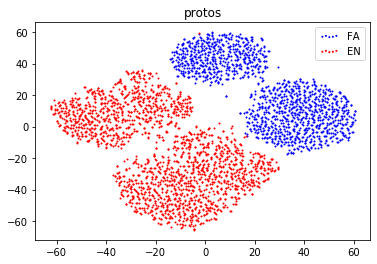

In [45]:
fig = plt.figure()
Y1 = Y[0:out_list.shape[0]]
out_label_1 = out_label[0:out_list.shape[0]]
Y2 = Y[out_list.shape[0]:]
out_label_2 = out_label[out_list.shape[0]:]
a = plt.scatter(Y1[:, 0], Y1[:, 1], color='b', s=1)
b = plt.scatter(Y2[:, 0], Y2[:, 1], color='r', s=1)
plt.legend([a, b],['FA', 'EN'], scatterpoints=5)
plt.title('protos')

In [46]:
# enroll sdsv21

In [47]:
enrollfilename = enroll_list
enroll_files = {}
## Read all enroll lines
with open(enrollfilename) as listfile:
    while True:
        line = listfile.readline()
        if (not line):
            break

        data = line.split();

        ## Enroll file should have line length >= 2
        assert len(data) >= 2

        enroll_files[data[0]] = data[1:]

In [48]:
len(enroll_files)

15555

In [49]:
enroll_dict = {}

In [50]:
for count, enroll_id in enumerate(enroll_files):
    for file in enroll_files[enroll_id]:
        wavline = file
        wavline = os.path.join(test_path, wavline)
        raw_inp = loadWAV(wavline, max_frames=0)
        raw_inp = torch.FloatTensor(raw_inp).cuda()

        ref_feat = S.forward(raw_inp).detach().cpu()

        if enroll_id not in enroll_dict.keys():
            enroll_dict[enroll_id] = ref_feat
        else:
            enroll_dict[enroll_id] = torch.cat([enroll_dict[enroll_id], ref_feat], axis=0)

    print(count+1, end='\r')


In [51]:
enroll_dict_nm = {}
for i in enroll_dict:
    enroll_dict_nm[i] = F.normalize(torch.mean(enroll_dict[i], dim=0).squeeze(0), p=2, dim=0)

In [52]:
len(enroll_dict_nm)

15555

In [53]:
# test sdsv21

In [54]:
listfilename = test_list
files = []
with open(listfilename) as listfile:
    while True:
        line = listfile.readline()
        if (not line):
            break

        data = line.split()

        if len(data) == 2: data = [random.randint(0,1)] + data

        files.append(data[2])

setfiles = list(set(files))
setfiles.sort()

In [55]:
len(setfiles)

69542

In [56]:
test_dict = {}

In [57]:
for count, line in enumerate(setfiles):
    wavline = line
    wavline = os.path.join(test_path, wavline)
    raw_inp = loadWAV(wavline, max_frames=0)
    raw_inp = torch.FloatTensor(raw_inp).cuda()
    
    ref_feat = S.forward(raw_inp).detach().cpu()

    test_dict[line] = ref_feat
    
    if ((count+1) % 1000) == 0:
        print((count+1)//1000, end='\r')

In [58]:
len(test_dict)

69542

In [59]:
test_dict_nm = {}
for i in test_dict:
    test_dict_nm[i] = F.normalize(test_dict[i].squeeze(0), p=2, dim=0)

In [60]:
### optional
# import pickle
# with open('tmp_chort_dict', 'wb') as f:
#     pickle.dump(cohort_spk_dict, f)
# import pickle
# with open('tmp_test_dict', 'wb') as f:
#     pickle.dump(test_dict, f)

In [61]:
15555 * 1417 // 100000

220

In [62]:
69542 * 1417 // 100000

985

In [63]:
count = 0
cohort2enroll = {}
for i in cohort_FA_spk_dict_mean_nm:
    cohort_emb = cohort_FA_spk_dict_mean_nm[i]
    for j in enroll_dict_nm:
        enroll_emb = enroll_dict_nm[j]
        score = F.cosine_similarity(cohort_emb, enroll_emb, dim=0).numpy().astype(numpy.float16)
        cohort2enroll[str(i)+" "+j] = score

        count += 1
        if (count % 100000) == 0:
            print(count // 100000, end='\r')
                
print(count)

22041435


In [64]:
count = 0
cohort2test = {}
for i in cohort_FA_spk_dict_mean_nm:
    cohort_emb = cohort_FA_spk_dict_mean_nm[i]
    for j in test_dict_nm:
        test_emb = test_dict_nm[j]
        score = F.cosine_similarity(cohort_emb, test_emb, dim=0).numpy().astype(numpy.float16)
        cohort2test[str(i)+" "+j] = score

        count += 1
        if (count % 100000) == 0:
            print(count // 100000, end='\r')
                
print(count)

98541014


In [65]:
len(cohort2test)

98541014

In [66]:
cohort2enroll_save_path = os.path.join(result_path, 'tmp_cohort2enroll.txt')
cohort2test_save_path = os.path.join(result_path, 'tmp_cohort2test.txt')

In [67]:
with open(cohort2enroll_save_path, 'w') as f:
    for count, i in enumerate(cohort2enroll):
        line = '%s %.4f\n'%(i, cohort2enroll[i])
        f.write(line)
        if (count % 100000) == 0:
            print(count // 100000, end='\r')

In [68]:
with open(cohort2test_save_path, 'w') as f:
    for count, i in enumerate(cohort2test):
        line = '%s %.4f\n'%(i, cohort2test[i])
        f.write(line)
        if (count % 100000) == 0:
            print(count // 100000, end='\r')

In [69]:
cohort2enroll = None
cohort2test = None

In [70]:
## optional
# import pickle
# with open('tmp_chort_dict', 'wb') as f:
#     pickle.dump(cohort2test, f)
# import pickle
# with open('tmp_test_dict', 'wb') as f:
#     pickle.dump(test_dict, f)

In [71]:
import torch
import sys
import os
import torch
import numpy
import torch.nn.functional as F
from scipy.io import wavfile
from collections import defaultdict

def as_norm_1(file_score_path, out_path, cohort2enroll_path, cohort2test_path, top_num=1000, hold_name=True, dict_sep=' '):
    # operation: norm_score = 0.5* ((score-mean_e_e)/str_e_e+(score-mean_t_t)/str_t_t)
    print('Score norm operation start, method: Adaptive_score_norm_type_1')
    print('')
    
    file_scores_as_norm_path = out_path
    enroll_dict = defaultdict(list)
    test_dict = defaultdict(list)

    with open(cohort2enroll_path, 'r') as f:
        for count, i in enumerate(f):
            cohort_utt, enroll_utt, score = i.strip().split(dict_sep)
            score = float(score)
            enroll_dict[enroll_utt].append([cohort_utt, score])
            if ((count+1) % 100000) == 0:
                print('read c2e:', (count+1)//100000, end='\r')
    
    with open(cohort2test_path, 'r') as f:
        for count, i in enumerate(f):
            cohort_utt, test_utt, score = i.strip().split(dict_sep)
            score = float(score)
            test_dict[test_utt].append([cohort_utt, score])
            if ((count+1) % 100000) == 0:
                print('read c2t:', (count+1)//100000, end='\r')
                
        
    mean_e_e = {}
    str_e_e = {}
    mean_t_t = {}
    str_t_t = {}
    
    print('')
    print('calculate enroll statistics')
    print('')
    
    for count, key in enumerate(enroll_dict):
        enroll_dict[key] = sorted(enroll_dict[key],key = lambda x:x[1], reverse = True)
        tmp_score_list = []
        for i in range(top_num):
            tmp_score_list.append(enroll_dict[key][i][1])
        mean_e_e[key] = numpy.mean(tmp_score_list)
        str_e_e[key] = numpy.std(tmp_score_list, ddof=1)
        if ((count+1) % 1000) == 0:
            print('cal e:', (count+1)//1000, end='\r')

    for count, key in enumerate(test_dict):
        test_dict[key] = sorted(test_dict[key],key = lambda x:x[1], reverse = True)
        tmp_score_list = []
        for i in range(top_num):
            tmp_score_list.append(test_dict[key][i][1])
        mean_t_t[key] = numpy.mean(tmp_score_list)
        str_t_t[key] = numpy.std(tmp_score_list, ddof=1)
        if ((count+1) % 1000) == 0:
            print('cal t:', (count+1)//1000, end='\r')

    print('')    
    print('Scoring...')
    print('')
    
    file_scores = open(file_score_path)
    with open(file_scores_as_norm_path,'w') as f:
        for count, line in enumerate(file_scores):
            enroll_utt = line.split(' ')[1].strip()
            test_utt = line.split(' ')[2].strip()
            score = float(line.split(' ')[0].strip())
            norm_score = 0.5 * ((score-mean_e_e[enroll_utt])/str_e_e[enroll_utt]+(score-mean_t_t[test_utt])/str_t_t[test_utt])
            if hold_name:
                f.write('%.4f %s %s\n'%(norm_score, enroll_utt, test_utt))
            else:
                f.write('%.4f\n'%(norm_score))
            
            if ((count+1) % 10000) == 0:
                print((count+1)//10000, end='\r')
                
    file_scores.close()
    print('')
    print('Adaptive_score_norm_type_1 is finished')

In [76]:
as_norm_1(score_file, out_path_1, cohort2enroll_save_path, cohort2test_save_path, top_num=300, hold_name=True)

Score norm operation start, method: Adaptive_score_norm_type_1

read c2t: 985 220
calculate enroll statistics

cal t: 69
Scoring...

461
Adaptive_score_norm_type_1 is finished


In [73]:
# as_norm_2(score_file, out_path_2, cohort2test, cohort2test, top_num=1000, hold_name=True)

In [74]:
# get asnormed score_file & scoring